In [1]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from io import BytesIO
import requests
import numpy as np
from captum.attr import visualization as viz
from captum.attr import Occlusion
import json

/Users/stavrostheocharis/projects/xai_demo/.xenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = torchvision.models.resnet50(pretrained=True).eval()


/Users/stavrostheocharis/projects/xai_demo/.xenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/stavrostheocharis/projects/xai_demo/.xenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
response = requests.get("https://unsplash.com/photos/aGQMKvPiBN4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8M3x8c3F1aXJyZWwlMjBtb25rZXl8ZW58MHx8fHwxNjc1NzczNTIy&force=true")
image = Image.open(BytesIO(response.content))

In [4]:
def process_image(image):
    center_crop = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        ])

    normalize = transforms.Compose([
        # convert the image to a tensor with values between 0 and 1
        transforms.ToTensor(), 
        # normalize to follow 0-centered imagenet pixel rgb distribution              
        transforms.Normalize(                
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
        ])
    return normalize(center_crop(image)).unsqueeze(0)

In [5]:
def load_data_labels(path: str =  'imagenet_class_index.json'):
    # Opening JSON file
    f = open(path)
    # returns JSON object as 
    # a dictionary
    data = json.load(f)

    return data

In [6]:
def predict_classes(input_img, labels, total_preds:int=5):
    # Find the score in terms of percentage by using torch.nn.functional.softmax function
    # which normalizes the output to range [0,1] and multiplying by 100
    out = model(input_img)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100

    # Find the index (tensor) corresponding to the maximum score in the out tensor.
    # Torch.max function can be used to find the information
    _, indices = torch.sort(out, descending=True)
    prediction = [(idx.item(), labels[str(idx.item())][1], percentage[idx].item()) for idx in indices[0][:total_preds]]
    
    return prediction

In [7]:
def create_attribution(target, model, input_img):
    occlusion = Occlusion(model)
    strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
    sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
    baselines = 0                     # values to occlude the image with. 0 corresponds to gray
    attribution = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)
    
    trans_attribution = np.transpose(attribution.squeeze().cpu().detach().numpy(), (1,2,0))

    return trans_attribution

In [8]:
def get_prediction_name(predictions):
    name_of_prediction = predictions[0][1]
    name_of_prediction = name_of_prediction.capitalize().replace('_', ' ')
    return name_of_prediction

In [9]:
def create_explanation(attribution, image, name_of_prediction, vis_types=["blended_heat_map", "original_image"], vis_signs = ["all", "all"]):
    center_crop = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        ])
        
    _ = viz.visualize_image_attr_multiple(attribution,
                                      np.array(center_crop(image)),
                                      vis_types,
                                      vis_signs,
                                      ["Attribution for " + name_of_prediction, "Image"],
                                      show_colorbar = True
                                     )

In [10]:
labels = load_data_labels()
input_img = process_image(image)
prediction = predict_classes(input_img, labels, 5)
prediction_name = get_prediction_name(prediction)
trans_attribution = create_attribution(prediction[0][0], model, input_img)

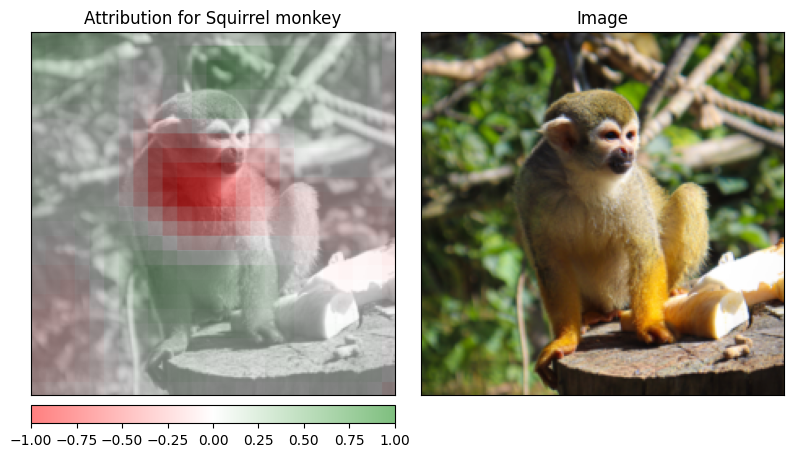

In [15]:
create_explanation(trans_attribution, image, prediction_name, vis_types=["blended_heat_map", "original_image"], vis_signs = ["all","all"])

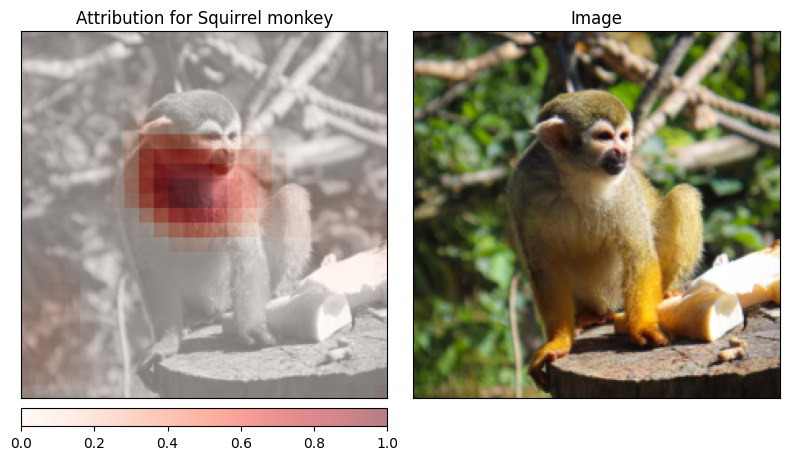

In [16]:
create_explanation(trans_attribution, image, prediction_name, vis_types=["blended_heat_map", "original_image"], vis_signs = ["negative","all"])

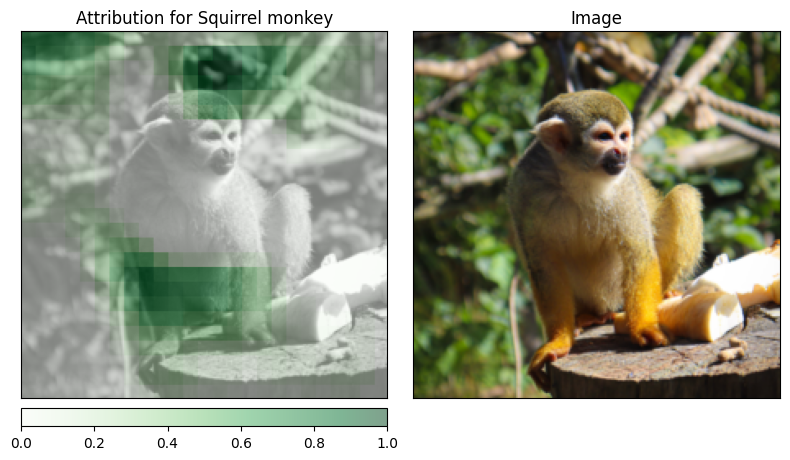

In [11]:
create_explanation(trans_attribution, image, prediction_name, vis_types=["blended_heat_map", "original_image"], vis_signs = ["positive","all"])

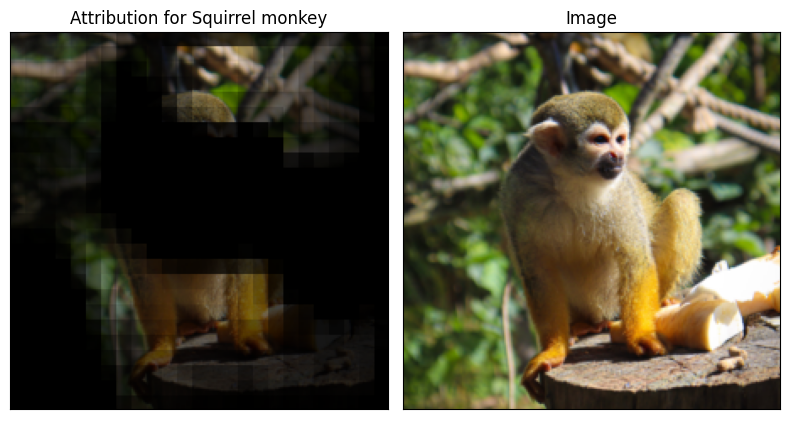

In [12]:
create_explanation(trans_attribution, image, prediction_name, vis_types=["masked_image", "original_image"], vis_signs = ["positive","all"])

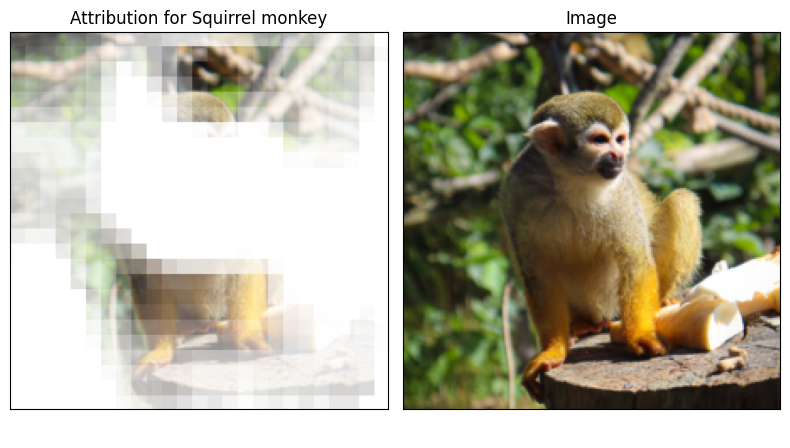

In [13]:
create_explanation(trans_attribution, image, prediction_name, vis_types=["alpha_scaling", "original_image"], vis_signs = ["positive","all"])